In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [28]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

In [29]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

# NEW
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # NEW: reserve part of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

#NEW
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

#NEW
test_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation'
)


Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [30]:
# Build a custom CNN model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolution block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second convolution block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third convolution block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Fourth convolution block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [31]:
# Create model
# model = build_model((*image_size, 3), train_data.num_classes)


# base_model = tf.keras.applications.ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(*image_size, 3)
# )
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces spatial dimensions
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')  # Output layer for class prediction
])


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
print("Training the custom CNN model...")
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

# Evaluation
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

Training the custom CNN model...
Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 704ms/step - accuracy: 0.3633 - loss: 1.3388 - val_accuracy: 0.4894 - val_loss: 0.9910 - learning_rate: 1.0000e-04
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 619ms/step - accuracy: 0.5328 - loss: 0.9859 - val_accuracy: 0.6383 - val_loss: 0.8226 - learning_rate: 1.0000e-04
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step - accuracy: 0.5731 - loss: 0.8613 - val_accuracy: 0.6099 - val_loss: 0.7878 - learning_rate: 1.0000e-04
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 628ms/step - accuracy: 0.6864 - loss: 0.7326 - val_accuracy: 0.6525 - val_loss: 0.7296 - learning_rate: 1.0000e-04
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 619ms/step - accuracy: 0.7312 - loss: 0.6757 - val_accuracy: 0.6738 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 621ms/step - accuracy: 0.7411 - loss: 0.6149 - val_accuracy: 0.7518 - val_loss: 0.6626 - learning_rate: 1.0000e-04
Epoch 7/15
18/18 ━━━━━━━━

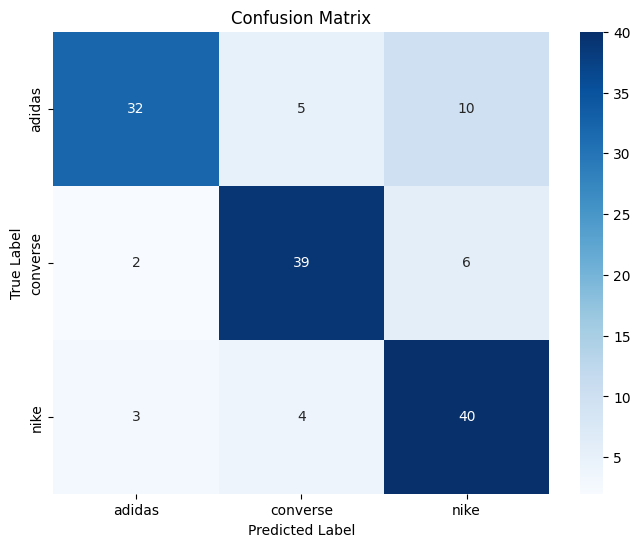

In [33]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.86      0.68      0.76        47
    converse       0.81      0.83      0.82        47
        nike       0.71      0.85      0.78        47

    accuracy                           0.79       141
   macro avg       0.80      0.79      0.79       141
weighted avg       0.80      0.79      0.79       141

